In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Create a Simple Synthetic Dataset

In [3]:
def create_synthetic_data(num_samples=1000, img_size=128):

    images = []
    masks = []

    for _ in range(num_samples):
        # Create blank image and mask
        img = np.zeros((img_size, img_size, 3), dtype=np.uint8)
        mask = np.zeros((img_size, img_size), dtype=np.uint8)

        # Randomly choose to add circle or rectangle (or both)
        shapes_to_add = np.random.choice([1, 2], size=np.random.randint(1, 3), replace=False)

        for shape in shapes_to_add:
            if shape == 1:  # Circle
                center = (np.random.randint(20, img_size-20), np.random.randint(20, img_size-20))
                radius = np.random.randint(10, 25)
                color = (np.random.randint(100, 255), np.random.randint(100, 255), np.random.randint(100, 255))

                cv2.circle(img, center, radius, color, -1)
                cv2.circle(mask, center, radius, 1, -1)

            elif shape == 2:  # Rectangle
                x1, y1 = np.random.randint(10, img_size//2), np.random.randint(10, img_size//2)
                x2, y2 = x1 + np.random.randint(20, 40), y1 + np.random.randint(20, 40)
                x2, y2 = min(x2, img_size-10), min(y2, img_size-10)
                color = (np.random.randint(100, 255), np.random.randint(100, 255), np.random.randint(100, 255))

                cv2.rectangle(img, (x1, y1), (x2, y2), color, -1)
                cv2.rectangle(mask, (x1, y1), (x2, y2), 2, -1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

images, masks = create_synthetic_data(num_samples=800, img_size=128)

## 3. Visualize Sample Data

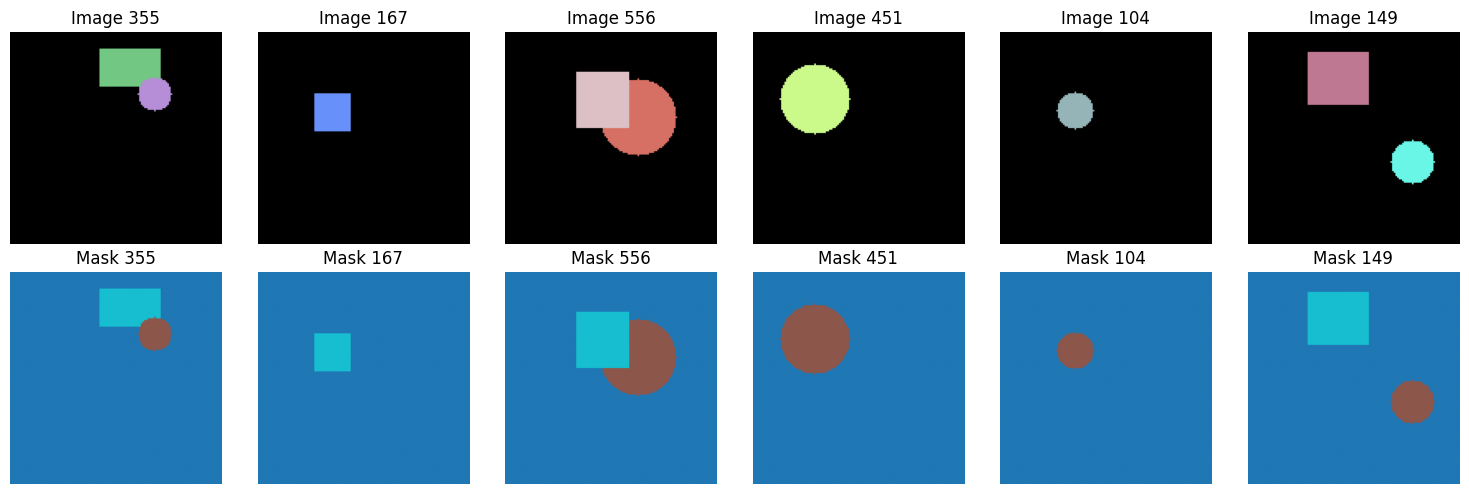


Class distribution in masks:
Class 0 (Background): 12001926 pixels (91.6%)
Class 1 (Circle): 561799 pixels (4.3%)
Class 2 (Rectangle): 543475 pixels (4.1%)


In [4]:
# Visualize some samples
fig, axes = plt.subplots(2, 6, figsize=(15, 5))

for i in range(6):
    idx = np.random.randint(0, len(images))

    # Original image
    axes[0, i].imshow(images[idx])
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Mask
    axes[1, i].imshow(masks[idx], cmap='tab10', vmax=2)
    axes[1, i].set_title(f'Mask {idx}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Show class distribution
unique, counts = np.unique(masks, return_counts=True)
print("\nClass distribution in masks:")
for class_id, count in zip(unique, counts):
    class_names = ['Background', 'Circle', 'Rectangle']
    print(f"Class {class_id} ({class_names[class_id]}): {count} pixels ({count/masks.size*100:.1f}%)")

## 4. Data Preprocessing and Dataset Class

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert to tensor and normalize
        image = torch.FloatTensor(image).permute(2, 0, 1) / 255.0  # (C, H, W) and normalize to [0, 1]
        mask = torch.LongTensor(mask)  # Keep as integers for cross-entropy loss

        return image, mask

# Split data into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_images)}")
print(f"Test samples: {len(test_images)}")

# Create datasets and dataloaders
train_dataset = SegmentationDataset(train_images, train_masks)
test_dataset = SegmentationDataset(test_images, test_masks)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 640
Test samples: 160
Train batches: 40
Test batches: 10


## 5. Simple CNN Architecture for Semantic Segmentation

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super(SimpleCNN, self).__init__()

        # Encoder (Downsampling path)
        self.encoder1 = self._conv_block(in_channels, 32)
        self.encoder2 = self._conv_block(32, 64)
        self.encoder3 = self._conv_block(64, 128)

        # Bottleneck
        self.bottleneck = self._conv_block(128, 256)

        # Decoder (Upsampling path)
        self.decoder3 = self._conv_block(256 + 128, 128)  # Skip connection
        self.decoder2 = self._conv_block(128 + 64, 64)    # Skip connection
        self.decoder1 = self._conv_block(64 + 32, 32)     # Skip connection

        # Final classifier
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def _conv_block(self, in_channels, out_channels):
        """Basic convolutional block with two conv layers"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)      # 128x128
        enc2 = self.encoder2(self.pool(enc1))  # 64x64
        enc3 = self.encoder3(self.pool(enc2))  # 32x32

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))  # 16x16

        # Decoder with skip connections
        dec3 = self.upsample(bottleneck)  # 32x32
        dec3 = torch.cat([dec3, enc3], dim=1)  # Skip connection
        dec3 = self.decoder3(dec3)

        dec2 = self.upsample(dec3)  # 64x64
        dec2 = torch.cat([dec2, enc2], dim=1)  # Skip connection
        dec2 = self.decoder2(dec2)

        dec1 = self.upsample(dec2)  # 128x128
        dec1 = torch.cat([dec1, enc1], dim=1)  # Skip connection
        dec1 = self.decoder1(dec1)

        # Final classification
        output = self.classifier(dec1)

        return output

# Create model and move to device
model = SimpleCNN(in_channels=3, num_classes=3).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model architecture:")
print(model)

Model created successfully!
Total parameters: 1,949,763
Trainable parameters: 1,949,763
Model architecture:
SimpleCNN(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(64, 128, ker

In [7]:
# Helper functions for training and evaluation
def calculate_iou(pred_mask, true_mask, num_classes=3):
    """
    Calculate Intersection over Union (IoU) for each class
    """
    ious = []
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)

    for cls in range(num_classes):
        pred_inds = pred_mask == cls
        target_inds = true_mask == cls
        intersection = (pred_inds[target_inds]).sum().float()
        union = pred_inds.sum().float() + target_inds.sum().float() - intersection
        if union == 0:
            ious.append(float('nan'))  # If no union, IoU is undefined
        else:
            ious.append((intersection / union).item())

    return ious

def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0

    for batch_idx, (images, masks) in enumerate(tqdm(dataloader, desc="Training")):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    total_loss = 0
    total_ious = [[] for _ in range(3)]  # For 3 classes

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            # Calculate IoU
            pred_masks = torch.argmax(outputs, dim=1)
            for i in range(images.size(0)):
                ious = calculate_iou(pred_masks[i], masks[i])
                for cls, iou in enumerate(ious):
                    if not np.isnan(iou):
                        total_ious[cls].append(iou)

    # Calculate mean IoU for each class
    mean_ious = [np.mean(cls_ious) if cls_ious else 0 for cls_ious in total_ious]

    return total_loss / len(dataloader), mean_ious


## 6. Train Simple CNN

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [9]:
num_epochs = 20
train_losses = []
val_losses = []
val_ious = []

print(f"Starting training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate
    val_loss, mean_ious = validate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_ious.append(mean_ious)

    # Update learning rate
    scheduler.step()

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"IoU - Background: {mean_ious[0]:.4f}, Circle: {mean_ious[1]:.4f}, Rectangle: {mean_ious[2]:.4f}")
    print(f"Mean IoU: {np.mean(mean_ious):.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print()

print("Training completed!")

Starting training for 20 epochs...

Epoch 1/20
------------------------------


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Train Loss: 0.4897
Val Loss: 0.3986
IoU - Background: 0.9954, Circle: 0.0000, Rectangle: 0.4780
Mean IoU: 0.4912
Learning Rate: 0.001000

Epoch 2/20
------------------------------


Training:   5%|▌         | 2/40 [00:07<02:21,  3.72s/it]


KeyboardInterrupt: 

## 7. Plot Training Results

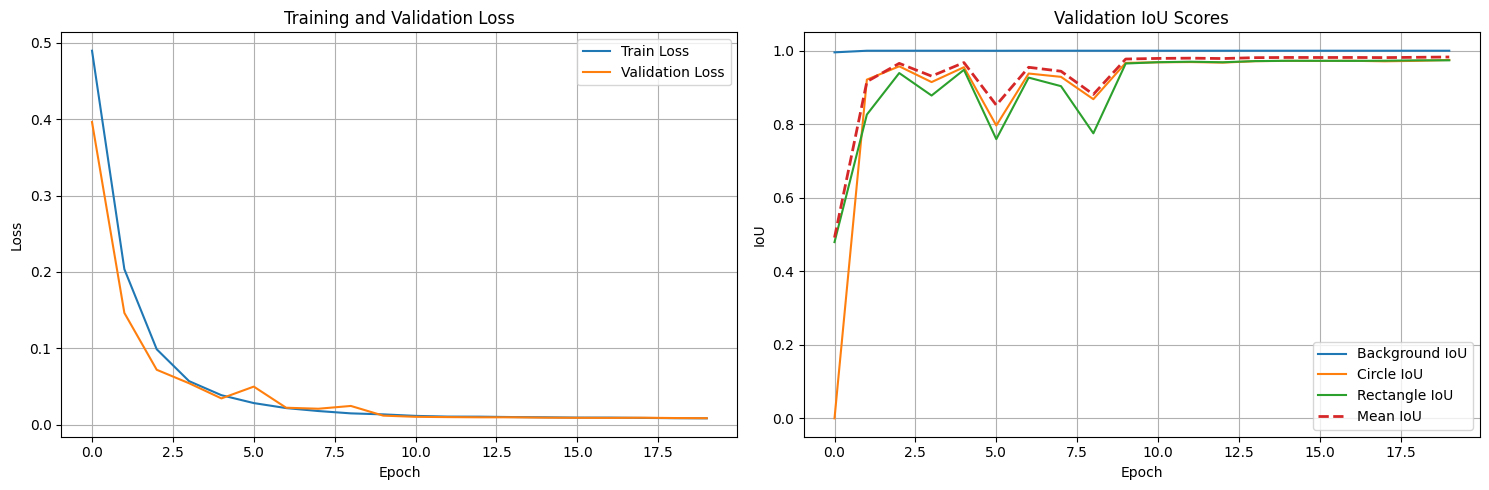

Final Validation Results:
Background IoU: 1.0000
Circle IoU: 0.9748
Rectangle IoU: 0.9739
Mean IoU: 0.9829


In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# IoU curves
val_ious_array = np.array(val_ious)
axes[1].plot(val_ious_array[:, 0], label='Background IoU')
axes[1].plot(val_ious_array[:, 1], label='Circle IoU')
axes[1].plot(val_ious_array[:, 2], label='Rectangle IoU')
axes[1].plot(np.mean(val_ious_array, axis=1), label='Mean IoU', linewidth=2, linestyle='--')
axes[1].set_title('Validation IoU Scores')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print final results
final_ious = val_ious[-1]
print(f"Final Validation Results:")
print(f"Background IoU: {final_ious[0]:.4f}")
print(f"Circle IoU: {final_ious[1]:.4f}")
print(f"Rectangle IoU: {final_ious[2]:.4f}")
print(f"Mean IoU: {np.mean(final_ious):.4f}")

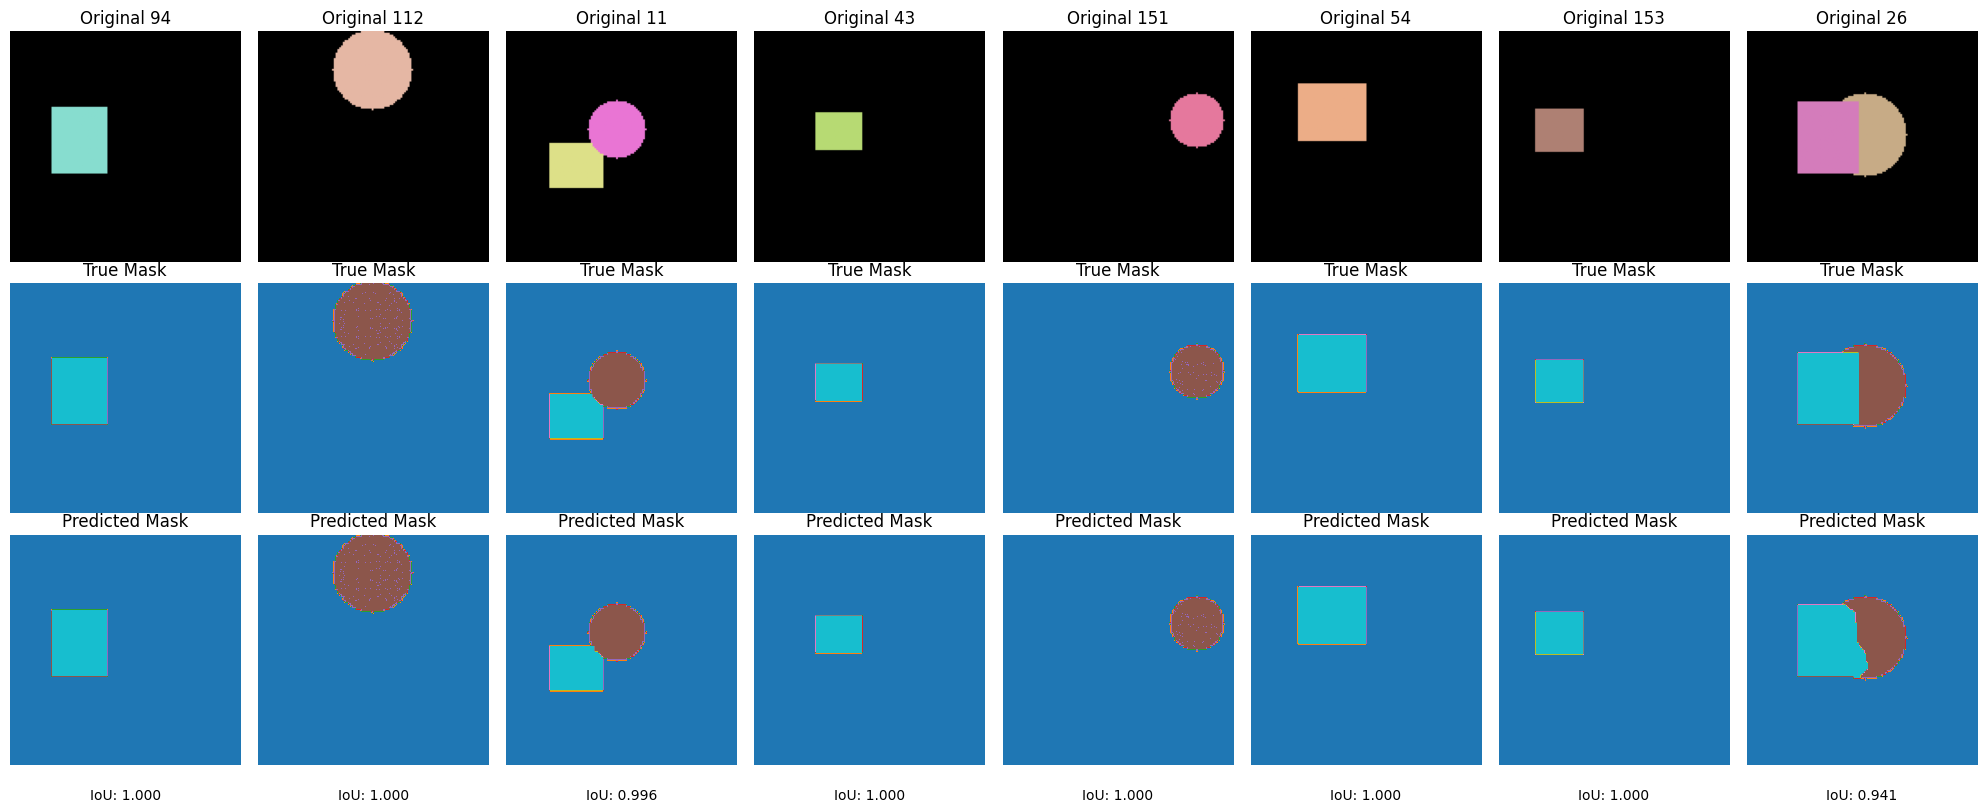

In [ ]:
def predict_and_visualize(model, test_dataset, device, num_samples=8):
    model.eval()

    # Get random samples from test set
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(3, num_samples, figsize=(20, 8))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_mask = test_dataset[idx]

            # Make prediction
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            pred_mask = torch.argmax(output, dim=1).cpu().numpy()[0]

            # Convert image for display
            display_image = image.permute(1, 2, 0).numpy()

            # Plot original image
            axes[0, i].imshow(display_image)
            axes[0, i].set_title(f'Original {idx}')
            axes[0, i].axis('off')

            # Plot true mask
            axes[1, i].imshow(true_mask.numpy(), cmap='tab10', vmax=2)
            axes[1, i].set_title('True Mask')
            axes[1, i].axis('off')

            # Plot predicted mask
            axes[2, i].imshow(pred_mask, cmap='tab10', vmax=2)
            axes[2, i].set_title('Predicted Mask')
            axes[2, i].axis('off')

            # Calculate IoU for this sample
            sample_ious = calculate_iou(torch.tensor(pred_mask), true_mask)
            mean_iou = np.nanmean(sample_ious)
            axes[2, i].text(0.5, -0.1, f'IoU: {mean_iou:.3f}',
                          ha='center', va='top', transform=axes[2, i].transAxes)

    plt.tight_layout()
    plt.show()

# Visualize predictions
predict_and_visualize(model, test_dataset, device, num_samples=8)

## 8. ResNet

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class ResNetSegmentation(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ResNetSegmentation, self).__init__()


        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        backbone_out_channels = 512

        # Decoder layers for upsampling
        self.decoder = nn.Sequential(
            # Upsample from 4x4 to 8x8
            nn.ConvTranspose2d(backbone_out_channels, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Upsample from 8x8 to 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Upsample from 16x16 to 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Upsample from 32x32 to 64x64
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Upsample from 64x64 to 128x128
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        # Final classifier
        self.classifier = nn.Conv2d(16, num_classes, kernel_size=1)

        # Initialize decoder weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize the decoder weights"""
        for m in self.decoder.modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Initialize classifier
        nn.init.kaiming_normal_(self.classifier.weight, mode='fan_out', nonlinearity='relu')
        if self.classifier.bias is not None:
            nn.init.constant_(self.classifier.bias, 0)

    def forward(self, x):
        # Extract features using ResNet backbone
        features = self.backbone(x)

        # Decode features to original resolution
        decoded = self.decoder(features)

        # Final classification
        output = self.classifier(decoded)

        return output

# Create ResNet-based model
resnet_model = ResNetSegmentation(num_classes=3, pretrained=True).to(device)

# Count parameters for comparison
resnet_total_params = sum(p.numel() for p in resnet_model.parameters())
resnet_trainable_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)

print("ResNet-based Segmentation Model Created!")
print(f"Total parameters: {resnet_total_params:,}")
print(f"Trainable parameters: {resnet_trainable_params:,}")
print(f"Parameters ratio (ResNet/SimpleCNN): {resnet_total_params/total_params:.2f}x")

# Test the model with a sample input
test_input = torch.randn(1, 3, 128, 128).to(device)
with torch.no_grad():
    resnet_output = resnet_model(test_input)
    print(f"\nModel test successful!")
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {resnet_output.shape}")


ResNet-based Segmentation Model Created!
Total parameters: 12,749,379
Trainable parameters: 12,749,379
Parameters ratio (ResNet/SimpleCNN): 6.54x

Model test successful!
Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


## 9. Train ResNet

In [ ]:
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
resnet_scheduler = optim.lr_scheduler.StepLR(resnet_optimizer, step_size=10, gamma=0.1)

Epoch 1/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.19it/s]


Train Loss: 0.3874
Val Loss: 0.1866
IoU - Background: 0.9682, Circle: 0.3664, Rectangle: 0.2669
Mean IoU: 0.5338
Learning Rate: 0.001000

Epoch 2/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.84it/s]


Train Loss: 0.1232
Val Loss: 0.1080
IoU - Background: 0.9692, Circle: 0.6391, Rectangle: 0.5531
Mean IoU: 0.7205
Learning Rate: 0.001000

Epoch 3/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.43it/s]


Train Loss: 0.0816
Val Loss: 0.0795
IoU - Background: 0.9805, Circle: 0.6495, Rectangle: 0.5991
Mean IoU: 0.7430
Learning Rate: 0.001000

Epoch 4/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 39.62it/s]


Train Loss: 0.0657
Val Loss: 0.0569
IoU - Background: 0.9830, Circle: 0.7641, Rectangle: 0.7663
Mean IoU: 0.8378
Learning Rate: 0.001000

Epoch 5/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 42.09it/s]


Train Loss: 0.0530
Val Loss: 0.0474
IoU - Background: 0.9861, Circle: 0.7773, Rectangle: 0.7682
Mean IoU: 0.8438
Learning Rate: 0.001000

Epoch 6/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.88it/s]


Train Loss: 0.0461
Val Loss: 0.0461
IoU - Background: 0.9862, Circle: 0.7884, Rectangle: 0.7708
Mean IoU: 0.8485
Learning Rate: 0.001000

Epoch 7/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.62it/s]


Train Loss: 0.0421
Val Loss: 0.0439
IoU - Background: 0.9854, Circle: 0.7841, Rectangle: 0.7856
Mean IoU: 0.8517
Learning Rate: 0.001000

Epoch 8/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.38it/s]


Train Loss: 0.0373
Val Loss: 0.0373
IoU - Background: 0.9883, Circle: 0.7938, Rectangle: 0.7684
Mean IoU: 0.8502
Learning Rate: 0.001000

Epoch 9/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.12it/s]


Train Loss: 0.0381
Val Loss: 0.0337
IoU - Background: 0.9886, Circle: 0.8434, Rectangle: 0.8258
Mean IoU: 0.8859
Learning Rate: 0.001000

Epoch 10/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.67it/s]


Train Loss: 0.0331
Val Loss: 0.0358
IoU - Background: 0.9874, Circle: 0.8126, Rectangle: 0.8078
Mean IoU: 0.8692
Learning Rate: 0.000100

Epoch 11/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 37.07it/s]


Train Loss: 0.0278
Val Loss: 0.0261
IoU - Background: 0.9923, Circle: 0.8746, Rectangle: 0.8670
Mean IoU: 0.9113
Learning Rate: 0.000100

Epoch 12/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 42.65it/s]


Train Loss: 0.0243
Val Loss: 0.0249
IoU - Background: 0.9928, Circle: 0.8861, Rectangle: 0.8747
Mean IoU: 0.9179
Learning Rate: 0.000100

Epoch 13/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 42.73it/s]


Train Loss: 0.0231
Val Loss: 0.0243
IoU - Background: 0.9930, Circle: 0.8856, Rectangle: 0.8794
Mean IoU: 0.9193
Learning Rate: 0.000100

Epoch 14/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.69it/s]


Train Loss: 0.0223
Val Loss: 0.0246
IoU - Background: 0.9928, Circle: 0.8768, Rectangle: 0.8753
Mean IoU: 0.9150
Learning Rate: 0.000100

Epoch 15/15
------------------------------


Validating: 100%|██████████| 10/10 [00:00<00:00, 41.16it/s]


Train Loss: 0.0219
Val Loss: 0.0240
IoU - Background: 0.9932, Circle: 0.8786, Rectangle: 0.8816
Mean IoU: 0.9178
Learning Rate: 0.000100

ResNet training completed!

FINAL PERFORMANCE COMPARISON
ResNet - Mean IoU: 0.9178
  Background: 0.9932, Circle: 0.8786, Rectangle: 0.8816


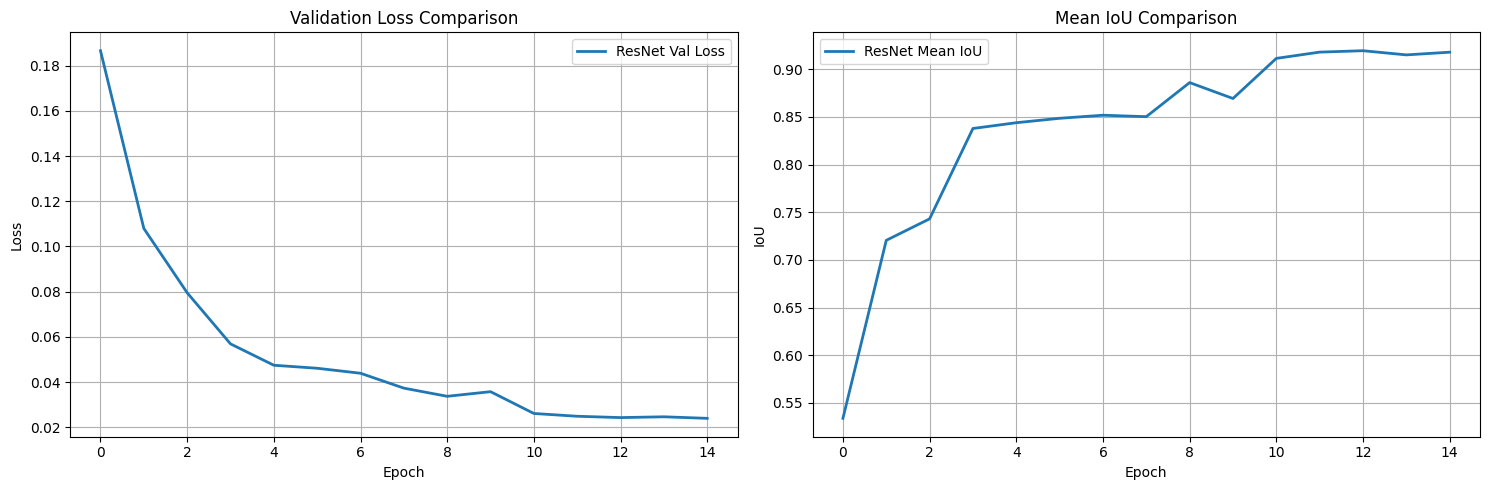

In [ ]:
resnet_num_epochs = 30  # Fewer epochs since we start with pretrained weights
resnet_train_losses = []
resnet_val_losses = []
resnet_val_ious = []


for epoch in range(resnet_num_epochs):
    print(f"Epoch {epoch+1}/{resnet_num_epochs}")
    print("-" * 30)

    # Train
    resnet_train_loss = train_epoch(resnet_model, train_loader, resnet_criterion, resnet_optimizer, device)
    resnet_train_losses.append(resnet_train_loss)

    # Validate
    resnet_val_loss, resnet_mean_ious = validate(resnet_model, test_loader, resnet_criterion, device)
    resnet_val_losses.append(resnet_val_loss)
    resnet_val_ious.append(resnet_mean_ious)

    # Update learning rate
    resnet_scheduler.step()

    # Print epoch results
    print(f"Train Loss: {resnet_train_loss:.4f}")
    print(f"Val Loss: {resnet_val_loss:.4f}")
    print(f"IoU - Background: {resnet_mean_ious[0]:.4f}, Circle: {resnet_mean_ious[1]:.4f}, Rectangle: {resnet_mean_ious[2]:.4f}")
    print(f"Mean IoU: {np.mean(resnet_mean_ious):.4f}")
    print(f"Learning Rate: {resnet_optimizer.param_groups[0]['lr']:.6f}")
    print()

print("ResNet training completed!")

# Compare final performance
print("\n" + "="*60)
print("FINAL PERFORMANCE COMPARISON")
print("="*60)


resnet_final_ious = resnet_val_ious[-1]

print(f"ResNet - Mean IoU: {np.mean(resnet_final_ious):.4f}")
print(f"  Background: {resnet_final_ious[0]:.4f}, Circle: {resnet_final_ious[1]:.4f}, Rectangle: {resnet_final_ious[2]:.4f}")


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(resnet_val_losses, label='ResNet Val Loss', linewidth=2)
axes[0].set_title('Validation Loss Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)


resnet_mean_ious_plot = [np.mean(iou) for iou in resnet_val_ious]
axes[1].plot(resnet_mean_ious_plot, label='ResNet Mean IoU', linewidth=2)
axes[1].set_title('Mean IoU Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 10. Compare Models:

In [ ]:
def compare_models(simple_model, resnet_model, test_loader, device):
    """
    Compare performance of both models on a sample batch
    """
    simple_model.eval()
    resnet_model.eval()

    # Get a sample batch
    sample_batch = next(iter(test_loader))
    images, true_masks = sample_batch
    images, true_masks = images.to(device), true_masks.to(device)

    with torch.no_grad():
        # Simple CNN predictions
        simple_outputs = simple_model(images)
        simple_preds = torch.argmax(simple_outputs, dim=1)

        # ResNet predictions
        resnet_outputs = resnet_model(images)
        resnet_preds = torch.argmax(resnet_outputs, dim=1)

        # Calculate accuracy for this batch
        simple_acc = (simple_preds == true_masks).float().mean().item()
        resnet_acc = (resnet_preds == true_masks).float().mean().item()

        print(f"Sample Batch Comparison:")
        print(f"SimpleCNN Accuracy: {simple_acc:.4f}")
        print(f"ResNet Accuracy: {resnet_acc:.4f}")

        # Visualize predictions side by side
        num_samples = min(4, images.size(0))
        fig, axes = plt.subplots(4, num_samples, figsize=(15, 12))

        for i in range(num_samples):
            # Original image
            img_display = images[i].cpu().permute(1, 2, 0).numpy()
            axes[0, i].imshow(img_display)
            axes[0, i].set_title(f'Original {i}')
            axes[0, i].axis('off')

            # True mask
            axes[1, i].imshow(true_masks[i].cpu().numpy(), cmap='tab10', vmax=2)
            axes[1, i].set_title('True Mask')
            axes[1, i].axis('off')

            # SimpleCNN prediction
            axes[2, i].imshow(simple_preds[i].cpu().numpy(), cmap='tab10', vmax=2)
            simple_iou = calculate_iou(simple_preds[i], true_masks[i])
            axes[2, i].set_title(f'SimpleCNN\nIoU: {np.nanmean(simple_iou):.3f}')
            axes[2, i].axis('off')

            # ResNet prediction
            axes[3, i].imshow(resnet_preds[i].cpu().numpy(), cmap='tab10', vmax=2)
            resnet_iou = calculate_iou(resnet_preds[i], true_masks[i])
            axes[3, i].set_title(f'ResNet\nIoU: {np.nanmean(resnet_iou):.3f}')
            axes[3, i].axis('off')

        plt.tight_layout()
        plt.show()

Sample Batch Comparison:
SimpleCNN Accuracy: 0.9986
ResNet Accuracy: 0.9911


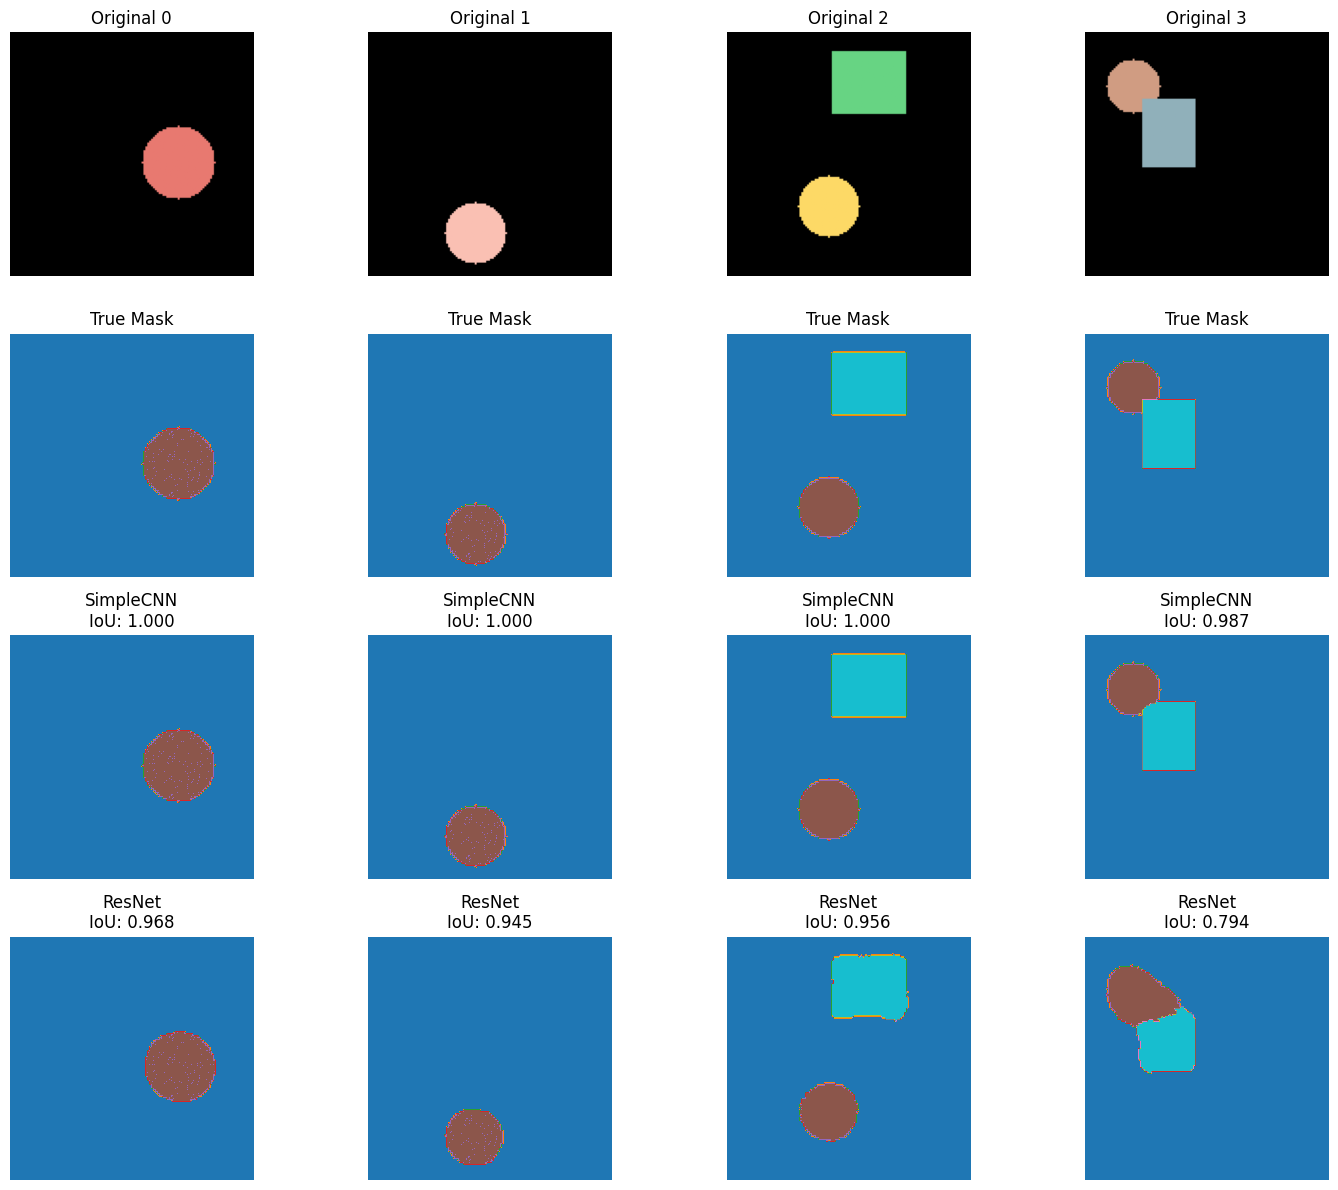

In [ ]:
compare_models(model, resnet_model, test_loader, device)

## 11. Visualize midel layer

In [ ]:
import torchvision.transforms as transforms
# Try to import torchsummary, but don't fail if it's not available
try:
    from torchsummary import summary
    TORCHSUMMARY_AVAILABLE = True
except ImportError:
    TORCHSUMMARY_AVAILABLE = False
    print("Note: torchsummary not available. Install with: pip install torchsummary")

def visualize_model_architecture(model, input_size=(3, 128, 128)):
    """
    Visualize the model architecture and parameter counts
    """
    print("=" * 60)
    print("MODEL ARCHITECTURE SUMMARY")
    print("=" * 60)

    if TORCHSUMMARY_AVAILABLE:
        try:
            summary(model, input_size)
        except Exception as e:
            print(f"torchsummary failed: {e}")
            print("Showing basic model structure:")
            print(model)
    else:
        print("Basic model structure:")
        print(model)

    print("\n" + "=" * 60)
    print("DETAILED LAYER INFORMATION")
    print("=" * 60)

    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            num_params = sum(p.numel() for p in module.parameters())
            print(f"{name:30} | {str(module):50} | Params: {num_params:,}")

def get_feature_maps(model, image, layer_names=None):
    """
    Extract feature maps from specified layers during forward pass
    """
    feature_maps = {}
    handles = []

    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach().cpu()
        return hook

    # Register hooks for all convolutional layers if layer_names not specified
    if layer_names is None:
        layer_names = []
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                layer_names.append(name)

    # Register hooks
    for name in layer_names:
        for module_name, module in model.named_modules():
            if module_name == name:
                handle = module.register_forward_hook(hook_fn(name))
                handles.append(handle)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(device))

    # Remove hooks
    for handle in handles:
        handle.remove()

    return feature_maps

def visualize_feature_maps(feature_maps, max_channels=16, figsize=(20, 12)):
    """
    Visualize feature maps from different layers
    """
    num_layers = len(feature_maps)
    fig, axes = plt.subplots(num_layers, max_channels, figsize=figsize)

    if num_layers == 1:
        axes = axes.reshape(1, -1)

    for layer_idx, (layer_name, feature_map) in enumerate(feature_maps.items()):
        # Get the first sample from batch and limit channels
        feature_map = feature_map[0]  # Remove batch dimension
        num_channels = min(feature_map.shape[0], max_channels)

        for channel_idx in range(max_channels):
            ax = axes[layer_idx, channel_idx]

            if channel_idx < num_channels:
                # Display the feature map
                fm = feature_map[channel_idx].numpy()
                im = ax.imshow(fm, cmap='viridis')
                ax.set_title(f'{layer_name}\nCh {channel_idx}', fontsize=8)
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            else:
                # Hide unused subplots
                ax.axis('off')
                ax.set_title('', fontsize=8)

            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

def analyze_layer_activations(feature_maps):
    """
    Analyze activation statistics for each layer
    """
    print("=" * 80)
    print("LAYER ACTIVATION ANALYSIS")
    print("=" * 80)
    print(f"{'Layer Name':<25} {'Shape':<20} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 80)

    for layer_name, feature_map in feature_maps.items():
        fm = feature_map[0].numpy()  # Remove batch dimension
        shape = f"{fm.shape}"
        mean_val = np.mean(fm)
        std_val = np.std(fm)
        min_val = np.min(fm)
        max_val = np.max(fm)

        print(f"{layer_name:<25} {shape:<20} {mean_val:<10.3f} {std_val:<10.3f} {min_val:<10.3f} {max_val:<10.3f}")



Note: torchsummary not available. Install with: pip install torchsummary


Analyzing SimpleCNN architecture...
MODEL ARCHITECTURE SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          18,496
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 

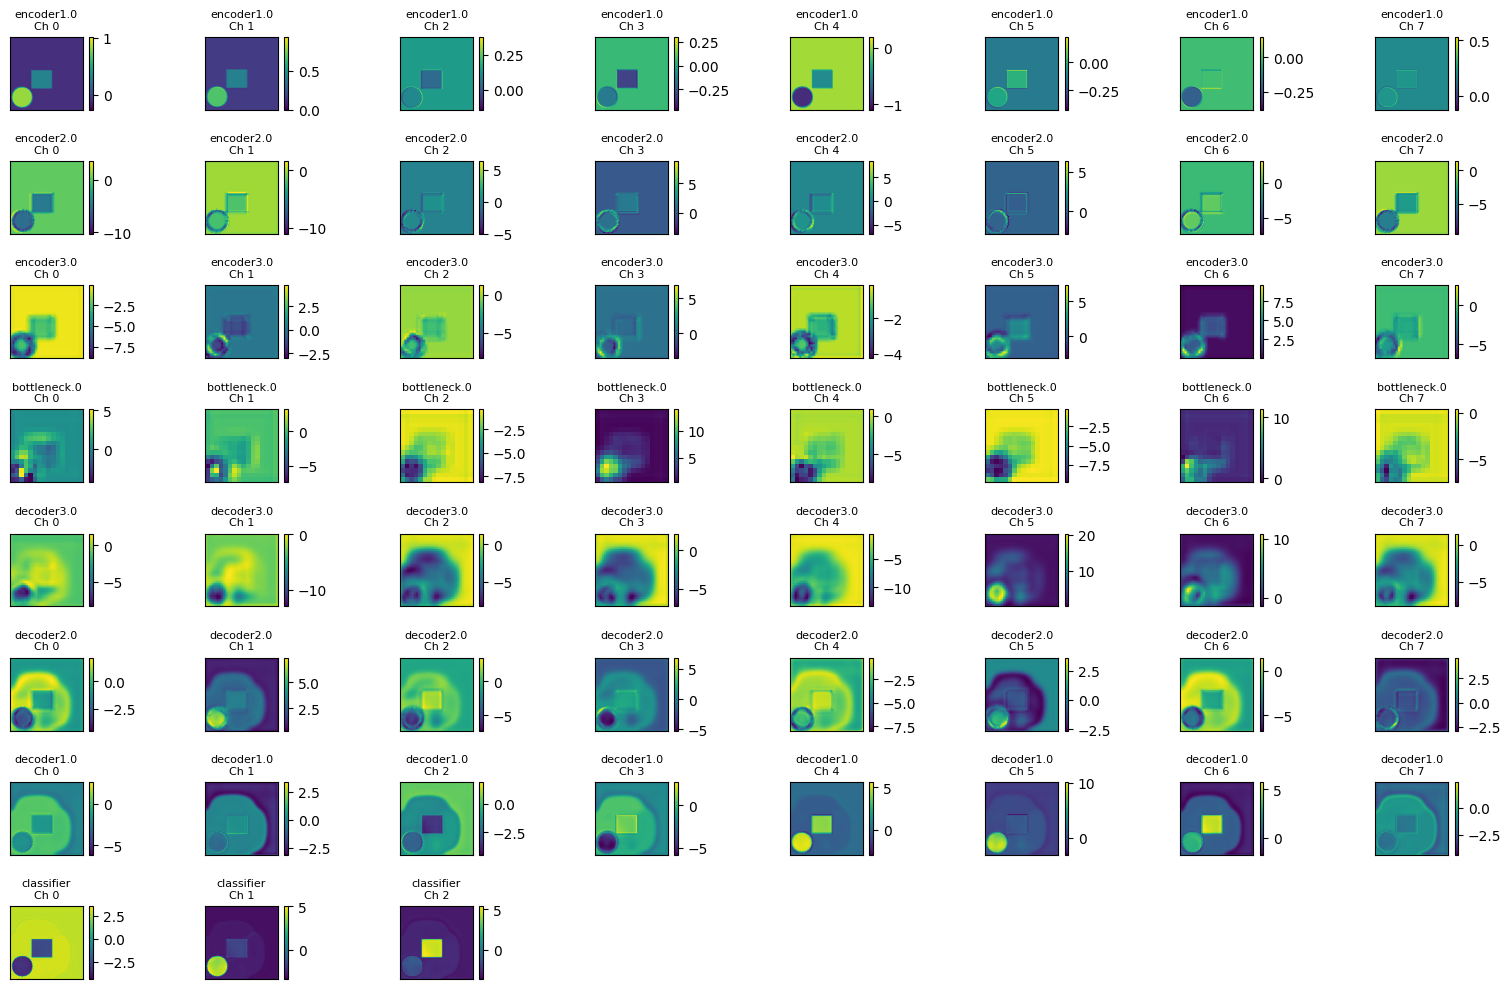

In [ ]:
import torchvision.transforms as transforms
# Try to import torchsummary, but don't fail if it's not available
try:
    from torchsummary import summary
    TORCHSUMMARY_AVAILABLE = True
except ImportError:
    TORCHSUMMARY_AVAILABLE = False
    print("Note: torchsummary not available. Install with: pip install torchsummary")

def visualize_model_architecture(model, input_size=(3, 128, 128)):
    """
    Visualize the model architecture and parameter counts
    """
    print("=" * 60)
    print("MODEL ARCHITECTURE SUMMARY")
    print("=" * 60)

    if TORCHSUMMARY_AVAILABLE:
        try:
            summary(model, input_size)
        except Exception as e:
            print(f"torchsummary failed: {e}")
            print("Showing basic model structure:")
            print(model)
    else:
        print("Basic model structure:")
        print(model)

    print("\n" + "=" * 60)
    print("DETAILED LAYER INFORMATION")
    print("=" * 60)

    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only leaf modules
            num_params = sum(p.numel() for p in module.parameters())
            print(f"{name:30} | {str(module):50} | Params: {num_params:,}")

def get_feature_maps(model, image, layer_names=None):
    """
    Extract feature maps from specified layers during forward pass
    """
    feature_maps = {}
    handles = []

    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach().cpu()
        return hook

    # Register hooks for all convolutional layers if layer_names not specified
    if layer_names is None:
        layer_names = []
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                layer_names.append(name)

    # Register hooks
    for name in layer_names:
        for module_name, module in model.named_modules():
            if module_name == name:
                handle = module.register_forward_hook(hook_fn(name))
                handles.append(handle)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(device))

    # Remove hooks
    for handle in handles:
        handle.remove()

    return feature_maps

def visualize_feature_maps(feature_maps, max_channels=16, figsize=(20, 12)):
    """
    Visualize feature maps from different layers
    """
    num_layers = len(feature_maps)
    fig, axes = plt.subplots(num_layers, max_channels, figsize=figsize)

    if num_layers == 1:
        axes = axes.reshape(1, -1)

    for layer_idx, (layer_name, feature_map) in enumerate(feature_maps.items()):
        # Get the first sample from batch and limit channels
        feature_map = feature_map[0]  # Remove batch dimension
        num_channels = min(feature_map.shape[0], max_channels)

        for channel_idx in range(max_channels):
            ax = axes[layer_idx, channel_idx]

            if channel_idx < num_channels:
                # Display the feature map
                fm = feature_map[channel_idx].numpy()
                im = ax.imshow(fm, cmap='viridis')
                ax.set_title(f'{layer_name}\nCh {channel_idx}', fontsize=8)
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            else:
                # Hide unused subplots
                ax.axis('off')
                ax.set_title('', fontsize=8)

            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

def analyze_layer_activations(feature_maps):
    """
    Analyze activation statistics for each layer
    """
    print("=" * 80)
    print("LAYER ACTIVATION ANALYSIS")
    print("=" * 80)
    print(f"{'Layer Name':<25} {'Shape':<20} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 80)

    for layer_name, feature_map in feature_maps.items():
        fm = feature_map[0].numpy()  # Remove batch dimension
        shape = f"{fm.shape}"
        mean_val = np.mean(fm)
        std_val = np.std(fm)
        min_val = np.min(fm)
        max_val = np.max(fm)

        print(f"{layer_name:<25} {shape:<20} {mean_val:<10.3f} {std_val:<10.3f} {min_val:<10.3f} {max_val:<10.3f}")

# Visualize the model architecture
print("Analyzing SimpleCNN architecture...")
visualize_model_architecture(model)

# Get a sample image for feature map visualization
sample_image, _ = train_dataset[0]
print(f"\nUsing sample image of shape: {sample_image.shape}")

# Extract feature maps from key layers
key_layers = ['encoder1.0', 'encoder2.0', 'encoder3.0', 'bottleneck.0',
              'decoder3.0', 'decoder2.0', 'decoder1.0', 'classifier']

feature_maps = get_feature_maps(model, sample_image, key_layers)
print(f"\nExtracted feature maps from {len(feature_maps)} layers")

# Analyze activation statistics
analyze_layer_activations(feature_maps)

# Visualize feature maps
print("\nVisualizing feature maps...")
visualize_feature_maps(feature_maps, max_channels=8, figsize=(16, 10))